In [43]:
# enrichment and feature ranking
import pandas as pd
from pickle import load
import cobra
import medusa
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [29]:
ensembles = {}
importances = {}
cluster_membership = {}
collapsed_features = {}
# exclude species that had non-variant ensemble structure or predictions.
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia','Achromobacter xylosoxidans','Achromobacter piechaudii']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            print(species_name)
            ensembles[species_name] = load(infile)

        # load the feature importance data for all species
        importances[species_name] = pd.read_csv('../results/classification_results/'+species_name+'_feature_importance.csv',sep=',', index_col = 0)

        # save the cluster membership information
        cluster_membership[species_name] = pd.read_csv('../results/classification_results/'+species_name+'_clusters.csv',sep=',')

        # load the collapsed feature sets
        with open('../results/collapsed_features/'+species_name+'_collapsed_features.json','r') as jsonfile:
            collapsed_features[species_name] = json.load(jsonfile)

Streptococcus equinus
Aeromonas salmonicida
Flavobacterium johnsoniae
Ralstonia solanacearum
Streptococcus mitis
Bacillus pumilus
Enterococcus faecalis
Pseudomonas putida
Haemophilus parasuis
Chryseobacterium gleum
Staphylococcus haemolyticus
Neisseria mucosa
Listeria monocytogenes
Neisseria flavescens
Streptococcus pneumoniae
Haemophilus influenzae
Sphingobacterium spiritivorum
Ralstonia pickettii
Corynebacterium glutamicum
Staphylococcus epidermidis
Pseudomonas mendocina
Streptococcus gallolyticus
Staphylococcus aureus
Streptococcus oralis
Neisseria meningitidis
Corynebacterium efficiens
Streptococcus vestibularis
Pseudomonas stutzeri
Listeria seeligeri


In [145]:
# get the average fractional importance for each reaction.
# first, expand collapsed features and duplicate their fractional importance
reaction_fractional_importances = {}
reaction_fractional_differences = {}
reaction_fractional_ratio = {}
# save the same data to species-specific dictionaries so 
# we can more easily generate species-specific dataframes later
species_fractional_importances = {}
species_fractional_differences = {}
species_fractional_ratio = {}
for species in importances.keys():
    species_fractional_importances[species] = {}
    species_fractional_differences[species] = {}
    species_fractional_ratio[species] = {}
    for reaction in importances[species].index.values:
        # extract all reactions from the collapsed feature set
        subreactions = collapsed_features[species][reaction]
        # if all subreactions are lower bound features, remove the set. This set
        # just represents the lower bound of 0 for all irreversible reactions with a
        # feature.
        if 'upper_bound' in " ".join(subreactions):
            # get rid of upper/lower bound and _c suffix
            subreactions = [r.split('_')[0] for r in subreactions]
            # remove redundant features (upper/lower bound)
            subreactions = list(set(subreactions))

            for r in subreactions:
                # remember: all 'r's get assigned the same importance/difference as the label for the feature set, 'reaction'
                if r in reaction_fractional_importances.keys():
                    reaction_fractional_importances[r].append(importances[species].loc[reaction]['importance'])
                    reaction_fractional_differences[r].append(abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1']))
                    reaction_fractional_ratio[r].append(min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])/
                                                             max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1']))
                else:
                    reaction_fractional_importances[r] = [importances[species].loc[reaction]['importance']]
                    reaction_fractional_differences[r] = [abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1'])]
                    reaction_fractional_ratio[r] = [min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])/
                                                             max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])]
                    



                species_fractional_importances[species][r] = importances[species].loc[reaction]['importance']
                species_fractional_differences[species][r] = abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1'])
                species_fractional_ratio[species][r] = (min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])
                                                             /max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1']))

In [146]:
# Calculate means across the pan-species data
mean_fractional_importances = {r:np.mean(reaction_fractional_importances[r]) for r in reaction_fractional_importances.keys()}
mean_fractional_differences = {r:np.mean(reaction_fractional_differences[r]) for r in reaction_fractional_differences.keys()}
mean_fractional_ratios = {r:np.mean(reaction_fractional_ratio[r]) for r in reaction_fractional_ratio.keys()}
reaction_model_counts = {r:len(reaction_fractional_importances[r]) for r in reaction_fractional_importances.keys()}
zero_weighted_importances = {r:np.sum(reaction_fractional_importances[r])/len(importances.keys()) for r in reaction_fractional_importances.keys()}
zero_weighted_differences = {r:np.sum(reaction_fractional_differences[r])/len(importances.keys()) for r in reaction_fractional_differences.keys()}
for_df = {'mean fractional importance':mean_fractional_importances,
          'mean fractional difference':mean_fractional_differences,
          'zero-weighted importance':zero_weighted_importances,
          'zero-weighted difference':zero_weighted_differences,
          'species count':reaction_model_counts,
          'mean fractional ratio':mean_fractional_ratios}
means_as_df = pd.DataFrame.from_dict(for_df)

species_curation_dfs = {}
for species in species_fractional_importances.keys():
    for_df = {'fractional importance':species_fractional_importances[species],
          'fractional difference':species_fractional_differences[species],
          'fractional ratio':species_fractional_ratio[species]}
    species_curation_dfs[species] = pd.DataFrame.from_dict(for_df)

(array([  4.61600000e+03,   1.83000000e+02,   7.80000000e+01,
          6.60000000e+01,   2.70000000e+01,   2.50000000e+01,
          2.50000000e+01,   1.80000000e+01,   1.70000000e+01,
          9.00000000e+00,   1.60000000e+01,   4.00000000e+00,
          4.00000000e+00,   1.00000000e+01,   6.00000000e+00,
          5.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          7.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

Text(0.5,0,'Fractional importance in classifier')

Text(0,0.5,'Feature count')

Text(0.5,1,'Pan-species distribution of feature importances')

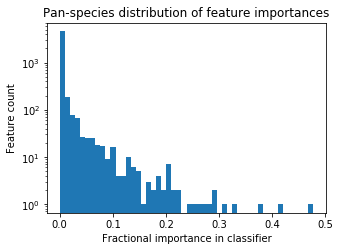

In [202]:
# plot the distribution of fractional importances and fractional ratios across the entire dataset
fig,ax = plt.subplots()
vals = []
for r in reaction_fractional_importances.keys():
    vals.extend(reaction_fractional_importances[r])
ax.hist(vals,bins=50)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of feature importances')
fig.set_size_inches(5,3.5)

plt.savefig('../results/curation_target_plots/feature_importance_distribution_SEED.svg')

In [147]:
sorted_df = means_as_df.sort_values(by='zero-weighted importance', ascending=False)
#sorted_df = sorted_df.sort_values(by='species count', ascending=False)
sorted_df

,mean fractional difference,mean fractional importance,mean fractional ratio,species count,zero-weighted difference,zero-weighted importance
rxn05291,0.264500,0.085019,0.626809,11,0.100328,0.032249
rxn30666,0.202152,0.049832,0.752612,13,0.090620,0.022338
rxn23629,0.268668,0.053011,0.514811,12,0.111173,0.021936
rxn01919,0.287927,0.057819,0.561612,11,0.109214,0.021931
rxn00958,0.148172,0.021721,0.712061,29,0.148172,0.021721
rxn11676,0.361326,0.089114,0.000000,7,0.087217,0.021510
rxn18456,0.147062,0.032534,0.624201,19,0.096351,0.021316
rxn04455,0.264337,0.050547,0.513555,12,0.109381,0.020916
rxn12298,0.283202,0.055131,0.560241,11,0.107421,0.020912
rxn00917,0.140625,0.030583,0.592397,15,0.072737,0.015819


In [169]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


def scatter_curation_targets(df,xvar,yvar,fname,sizevar=None,title=None):
    fig,ax = plt.subplots()

    x = df[xvar].values
    y = df[yvar].values
    
    if sizevar:
        s = df[sizevar].values*10
    else:
        s = 100
    
    ax.scatter(x,y,s=s, alpha = 0.3)
    ax.set_xlim((0,max(x)))
    ax.set_ylim((0,max(y)))
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    ax.set_title(title)
    fig.savefig(fname)

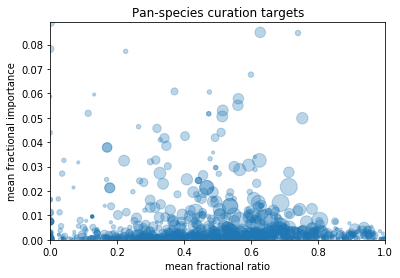

In [181]:
xvar = 'mean fractional ratio'
yvar = 'mean fractional importance'
df = sorted_df
sizevar = 'species count'
fname = '../results/curation_target_plots/panspecies.svg'
scatter_curation_targets(sorted_df,xvar,yvar,fname,sizevar,title='Pan-species curation targets')

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:522 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


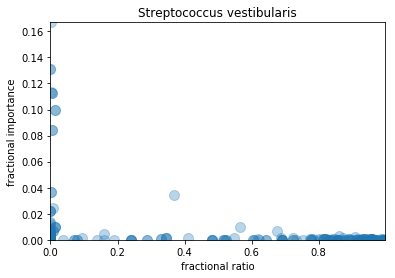

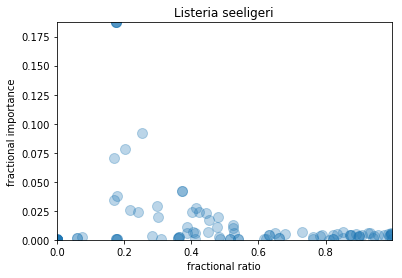

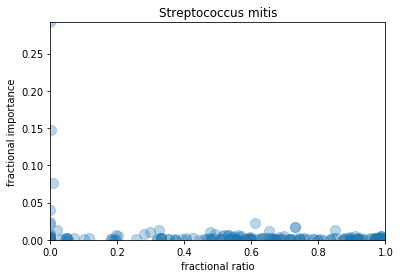

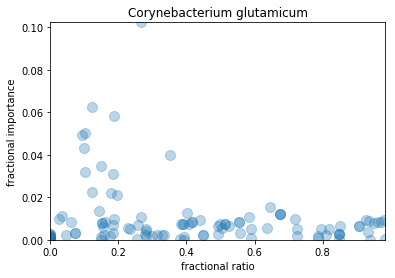

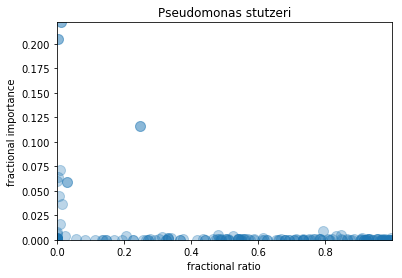

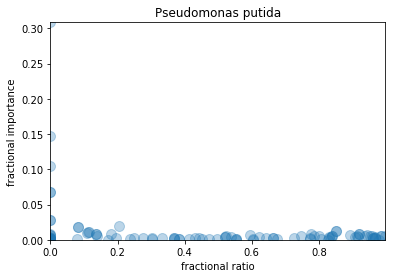

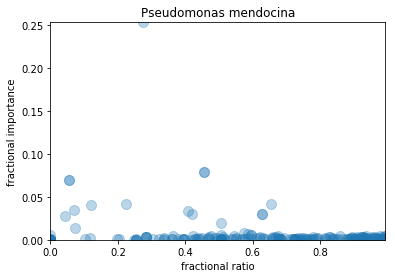

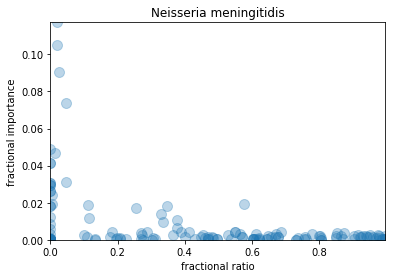

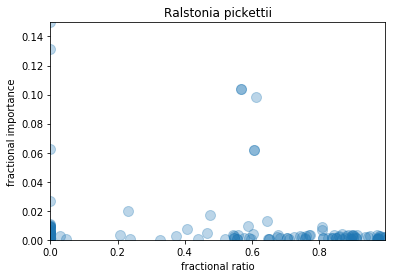

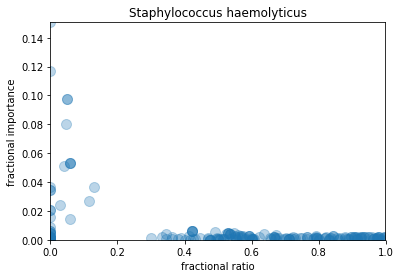

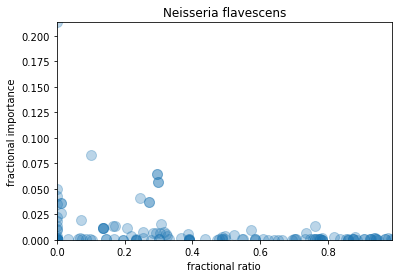

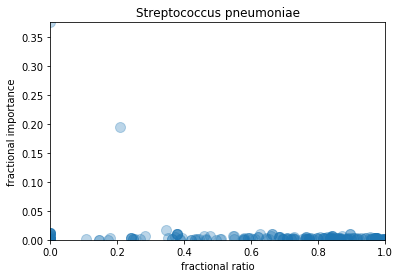

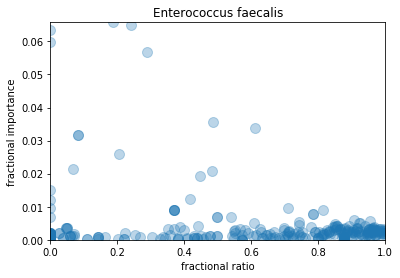

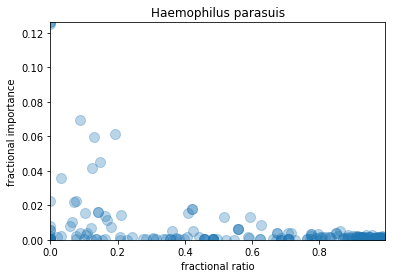

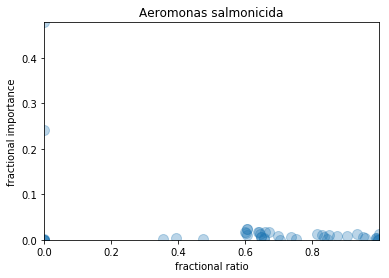

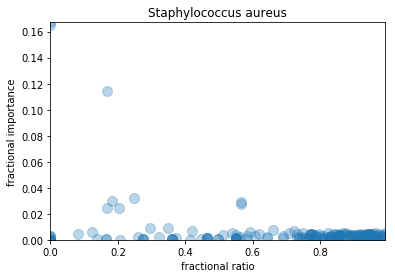

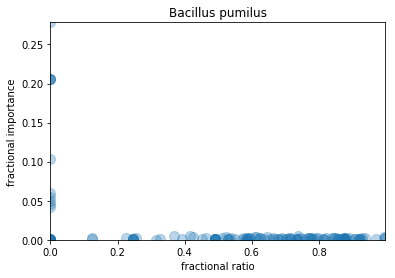

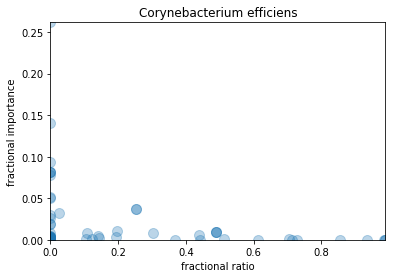

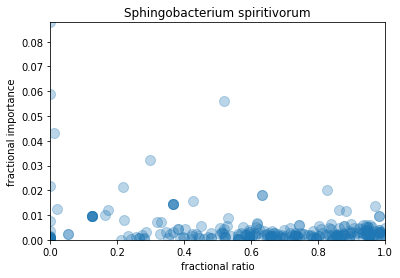

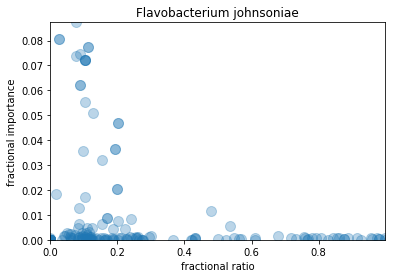

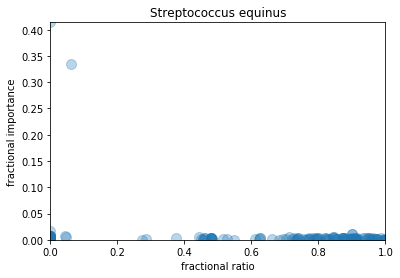

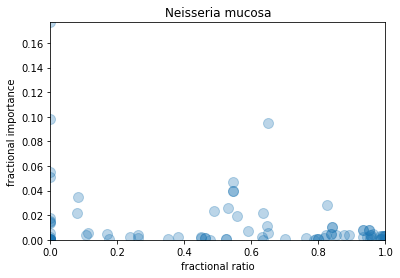

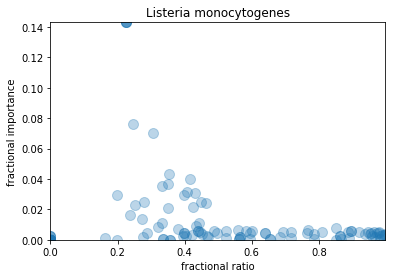

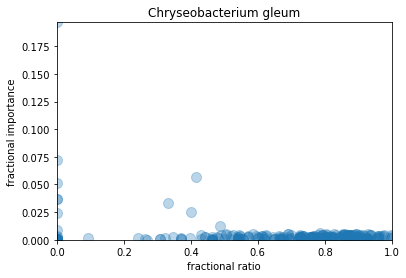

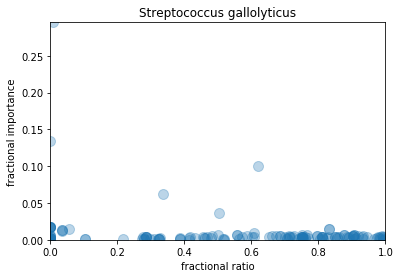

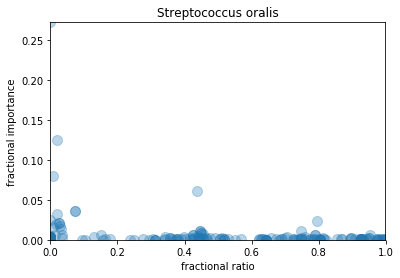

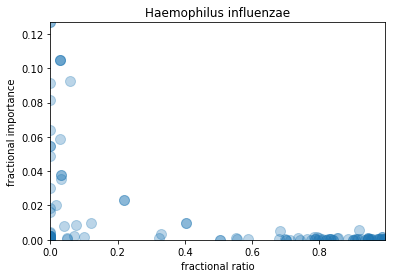

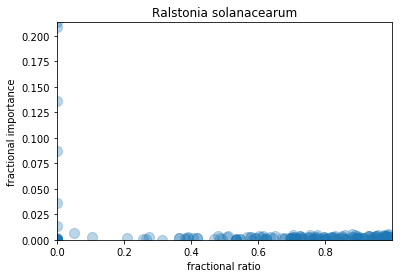

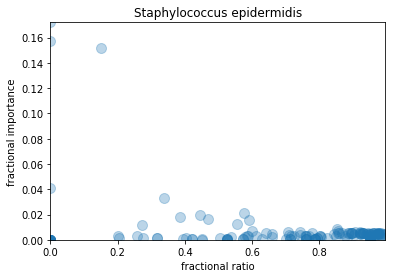

In [171]:
xvar = 'fractional ratio'
yvar = 'fractional importance'
for species in species_curation_dfs.keys():
    
    df = species_curation_dfs[species]
    fname = '../results/curation_target_plots/'+species+'_curation_targets.png'
    scatter_curation_targets(df,xvar,yvar,fname,title=species)